<a href="https://colab.research.google.com/github/MatthewHuang12/Banking_System/blob/main/ML_for_EMG_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML

## Tensorflow

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
s1_a1["emg"].shape

(130267, 16)

In [ ]:
s1_a1["repetition"].shape

(130267, 1)

In [ ]:
x = s1_a1["emg"]
y = s1_a1["repetition"]
y = tf.keras.utils.to_categorical(y)

for i in range(x.shape[1]):
    filtered, _ = conv_RMS(x[:, i], time_step)
    x[:, i] = np.pad(filtered, (0, x.shape[0] - filtered.shape[0]), 'constant')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [ ]:
def create_model(input_shape, classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(classes, activation='softmax')
    ])
    return model

In [ ]:
num_classes = 7
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = [CategoricalAccuracy()]
tf_model = create_model(x_train.shape[1], num_classes)
epochs = 10
batch_size = 16

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tf_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = tf_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - categorical_accuracy: 0.7551 - loss: 0.7981 - val_categorical_accuracy: 0.8521 - val_loss: 0.4458
Epoch 2/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - categorical_accuracy: 0.7184 - loss: 0.7957 - val_categorical_accuracy: 0.8514 - val_loss: 0.4219
Epoch 3/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - categorical_accuracy: 0.7219 - loss: 0.7883 - val_categorical_accuracy: 0.8577 - val_loss: 0.4222
Epoch 4/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - categorical_accuracy: 0.7263 - loss: 0.7769 - val_categorical_accuracy: 0.8593 - val_loss: 0.4138
Epoch 5/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - categorical_accuracy: 0.7276 - loss: 0.7750 - val_categorical_accuracy: 0.8632 - val_loss: 0.4064
Epoch 6/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - categorical_accuracy: 0.7308 - loss: 0.7674 - val_categorical_accuracy: 0.8622 - val_loss: 0.4018
Epoch 7/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - categorical_a

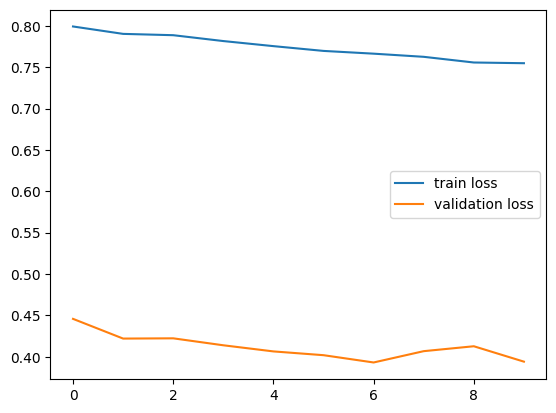

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
tf_model.evaluate(x_test, y_test)

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8455 - loss: 0.4454


[0.4417828321456909, 0.8483150601387024]

In [ ]:
# Inference
pred = tf_model.predict(x_test)
pred = np.argmax(pred, axis=1)
acc = np.mean(pred == np.argmax(y_test, axis=1))
print(f"Accuracy: {acc}")

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8483150379980041


## Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y


class EMGModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(EMGModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.softmax(self.fc4(x))
        return x

In [ ]:
x = s1_a1["emg"]
y = s1_a1["repetition"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_classes = 7
for i in range(x.shape[1]):
    filtered, _ = conv_RMS(x[:, i], time_step)
    x[:, i] = np.pad(filtered, (0, x.shape[0] - filtered.shape[0]), 'constant')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

train_dataset = EMGDataset(x_train, y_train)
test_dataset = EMGDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = EMGModel(x_train.shape[1], num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.to(device)

EMGModel(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=7, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
from tqdm import tqdm
epochs = 50

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0

    for batch, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        # pred = torch.argmax(pred, dim=1)

        print(pred.shape)
        print(y.shape)

        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    with torch.inference_mode():
        test_loss = 0.0
        correct = 0
        total = 0
        for batch, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            pred = torch.argmax(pred, dim=1)
            loss = criterion(pred, y)
            test_loss += loss.item()

            total += y.size(0)
            correct += (pred == y).sum().item()

        test_loss /= len(test_loader)

        accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-30-bed202aad898>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.x[idx], dtype=torch.float32)
<ipython-input-30-bed202aad898>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.y[idx], dtype=torch.float32)
  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 7])
torch.Size([16, 1])


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
torch.save(model.state_dict(), 'model.pth')